In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [80]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [42]:
import warnings

# 경고 무시하기
warnings.filterwarnings("ignore")
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
# 한글 텍스트를 제대로 표시하기 위해 'font.family' 사용
plt.rcParams['font.family'] = 'AppleGothic'

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

## EDA 수행 과정

### 1. 데이터 로딩 및 확인: 데이터를 불러오고, 특징(열)과 샘플(행)을 살펴보기

In [44]:
# 최종 전세 파일 오픈 
housing_price = pd.read_csv('./data_1/강남구전세데이터_찐마지막.csv', encoding='utf-8')
housing_price.head()

,AD_Code,Admin_District,Area,YearBuilt,Type,Floor,Address,Cont_Date,Age,Latitude,Longitude,Star_Cnt,Michelin_Cnt,Mc_cnt,Bigstore_cnt,InterestRate,Market_cnt,Subway_cnt,Kinder_cnt,y
0,0,개포동,44.0,1989,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-06-01,34,37.473722,127.052725,0,0,0,0,4.04,0,0,2,7500
1,0,개포동,44.0,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-10-05,32,37.473722,127.052725,0,0,0,0,4.82,0,0,2,14333
2,0,개포동,44.0,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-07-07,32,37.473722,127.052725,0,0,0,0,4.16,0,0,2,17115
3,0,개포동,44.0,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-07-07,32,37.473722,127.052725,0,0,0,0,4.16,0,0,2,17640
4,0,개포동,44.0,1989,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-06-01,34,37.473722,127.052725,0,0,0,0,4.04,0,0,2,7500


In [45]:
df = housing_price

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AD_Code         87361 non-null  int64  
 1   Admin_District  87361 non-null  object 
 2   Area            87361 non-null  float64
 3   YearBuilt       87361 non-null  int64  
 4   Type            87361 non-null  object 
 5   Floor           87361 non-null  float64
 6   Address         87361 non-null  object 
 7   Cont_Date       87361 non-null  object 
 8   Age             87361 non-null  int64  
 9   Latitude        87361 non-null  float64
 10  Longitude       87361 non-null  float64
 11  Star_Cnt        87361 non-null  int64  
 12  Michelin_Cnt    87361 non-null  int64  
 13  Mc_cnt          87361 non-null  int64  
 14  Bigstore_cnt    87361 non-null  int64  
 15  InterestRate    87361 non-null  float64
 16  Market_cnt      87361 non-null  int64  
 17  Subway_cnt      87361 non-null 

In [47]:
# Cont_Date 문자열 형태 -> datetime 으로 변경
df['Cont_Date'] = df['Cont_Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

### 2. 데이터 탐색: 기초 통계량, 데이터 분포, 이상치 등을 살펴보고 시각화를 활용하여 데이터를 이해

In [48]:
# 기술 통계 정보 요약 제공(평균, 표준편차, 최소값, 25%, 50%(중앙값), 75% 백분위수, 최대값)
df.describe()

,AD_Code,Area,YearBuilt,Floor,Age,Latitude,Longitude,Star_Cnt,Michelin_Cnt,Mc_cnt,Bigstore_cnt,InterestRate,Market_cnt,Subway_cnt,Kinder_cnt,y
count,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,87361.000000,8.736100e+04
mean,5.422694,67.776567,2000.491901,6.859915,22.508099,37.498124,127.057102,2.651034,1.253111,0.343162,0.528291,3.189517,0.132267,0.834732,1.074610,5.921226e+04
std,4.148519,37.183271,12.485836,5.758265,12.485836,0.015544,0.022320,2.424018,3.290181,0.520519,0.878938,0.669428,0.347259,0.811884,0.833464,4.606194e+04
min,0.000000,11.390000,1972.000000,-1.000000,0.000000,37.460288,127.018254,0.000000,0.000000,0.000000,0.000000,2.390000,0.000000,0.000000,0.000000,4.500000e+02
25%,2.000000,40.560000,1992.000000,3.000000,10.000000,37.488198,127.040612,0.000000,0.000000,0.000000,0.000000,2.560000,0.000000,0.000000,0.000000,2.520000e+04
50%,4.000000,59.920000,2002.000000,5.000000,21.000000,37.496665,127.051556,2.000000,0.000000,0.000000,0.000000,3.080000,0.000000,1.000000,1.000000,4.650000e+04
75%,9.000000,84.930000,2013.000000,10.000000,31.000000,37.508595,127.068504,4.000000,1.000000,1.000000,1.000000,3.510000,0.000000,1.000000,2.000000,8.000000e+04
max,13.000000,301.470000,2023.000000,67.000000,51.000000,37.533026,127.112686,10.000000,32.000000,2.000000,5.000000,4.820000,2.000000,3.000000,3.000000,1.100000e+06


In [49]:
# 데이터프레임의 문자열 열에 대한 기술 통계 요약 정보를 제공
# 결과로 문자열 열의 고유값 수, 최빈값, 데이터 개수, 유니크한 값 수 등이 출력. 
# 이를 통해 문자열 데이터의 특성을 파악
df.describe(include = 'object')

,Admin_District,Type,Address
count,87361,87361,87361
unique,14,4,3729
top,역삼동,아파트,서울특별시 강남구 삼성로 212
freq,14741,53963,2969


In [50]:
# 강남구 건물 건축년도 평균
df['YearBuilt'].mean()

2000.4919014205423

In [51]:
# 강남구 건물 평균적 연식
df['Age'].mean()

22.508098579457652

In [52]:
# 강남구 전세 이자율 평균
df['InterestRate'].mean()

3.1895174047922987

In [53]:
# 강남구 보증금 평균
df['y'].mean()

59212.25829603599

In [54]:
# 전세 보증금 중복값 제거 
df['y'].drop_duplicates().mean()

68727.807

###  분위수: df.quantile()

In [55]:
# 보증금 분위수 0.25
df['y'].quantile(0.25)

25200.0

In [56]:
# 0.25(25%) : 1사분위수(First Quartile) 로 데이터 25% 위치에 해당하는 값
# 0.5(50%) : 중앙값(Median) -> 데이터의 중간 값을 나타냄.
# 0.75(25%) : 3사분위수(Third Quartile) 로 데이터 25% 위치에 해당하는 값
df['y'].quantile([0.25, 0.5, 0.75])

0.25    25200.0
0.50    46500.0
0.75    80000.0
Name: y, dtype: float64

In [57]:
# 0.9(90%) : 데이터 90% 위치에 해당하는 값
df['y'].quantile(0.9)

120000.0

In [58]:
# unique() 메서드: 컬럼의 고유한 값 목록을 확인
print(df['AD_Code'].unique())
print(df['Admin_District'].unique())

[ 0  1  2  9  3  4  5  6  7 10 11 12 13  8]
['개포동' '논현동' '대치동' '역삼동' '도곡동' '삼성동' '세곡동' '수서동' '신사동' '율현동' '일원동' '자곡동'
 '청담동' '압구정동']


### 분산: df.var()

In [59]:
# 분산이란 데이터가 평균 주위에 얼마나 퍼져있는지를나타내는 중요한 통계량 중 하나
df['y'].var()

2121702395.9183118

In [60]:
df['Star_Cnt'].var()

5.875863427875852

### 표준편차: df.std()

In [61]:
# 데이터프레임의 각 열(Column)에 대한 표준 편차(standard deviation) 값을 계산하는 함수
# 표준 편차는 데이터의 분산 정도를 나타내는 지표, 값들이 평균으로부터 얼마나 퍼져 있는지 나타냄
df['y'].std()

46061.940861391326

### 최빈값 : df.mode()

In [62]:
### 범주형 변수의 경우에 사용, 해당 변수에서 가장 빈번하게 나타나는 범주를 파악하는데 사용
### 최빈값은 데이터의 분포를 이해하고, 특정 값이 데이터에서 얼마나 자주 나타나는지를 파악하는데 유용

# 보증금 최빈값
df['y'].mode()

0    50000
Name: y, dtype: int64

In [63]:
# 건축년도 최빈값
df['YearBuilt'].mode()

0    2014
Name: YearBuilt, dtype: int64

In [64]:
# 계약일자 최빈값
df['Cont_Date'].mode()

0   2022-05-11
Name: Cont_Date, dtype: datetime64[ns]

In [65]:
# 행개수, 컬럼개수 출력
print(df.shape)

(87361, 20)


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AD_Code         87361 non-null  int64         
 1   Admin_District  87361 non-null  object        
 2   Area            87361 non-null  float64       
 3   YearBuilt       87361 non-null  int64         
 4   Type            87361 non-null  object        
 5   Floor           87361 non-null  float64       
 6   Address         87361 non-null  object        
 7   Cont_Date       87361 non-null  datetime64[ns]
 8   Age             87361 non-null  int64         
 9   Latitude        87361 non-null  float64       
 10  Longitude       87361 non-null  float64       
 11  Star_Cnt        87361 non-null  int64         
 12  Michelin_Cnt    87361 non-null  int64         
 13  Mc_cnt          87361 non-null  int64         
 14  Bigstore_cnt    87361 non-null  int64         
 15  In

In [67]:
df['Cont_Date'].unique().max()

numpy.datetime64('2022-12-31T00:00:00.000000000')

### 분포 요약하기 

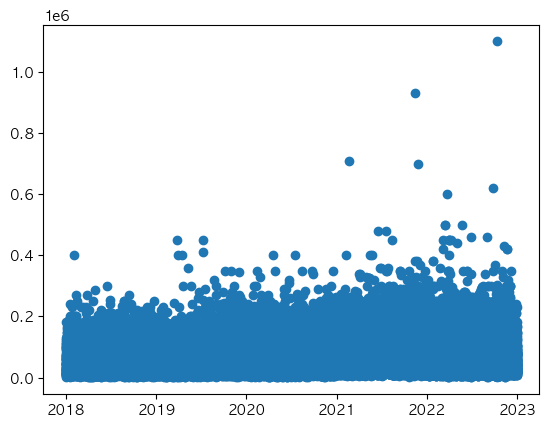

In [68]:
# 계약 기간 별로 보증금액 분포도 확인
import matplotlib.pyplot as plt
plt.scatter(df['Cont_Date'], df['y'])
plt.show()

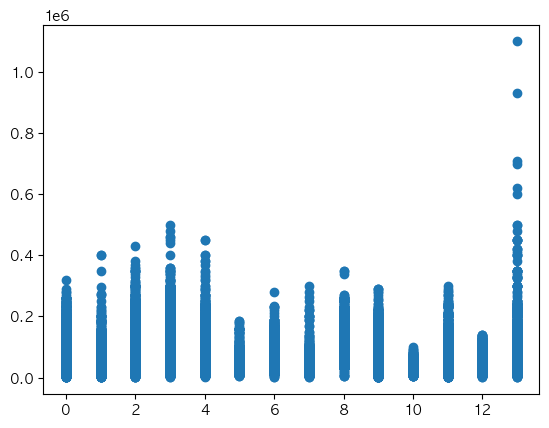

In [69]:
# 행정구역별 로 보증금 분포도 확인
# 행정구역 코드 13번인 청담동이 비싼 동네 ㅠ
plt.scatter(df['AD_Code'], df['y']) 
plt.show()

<Figure size 2000x1000 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, '상관관계 알아보기')

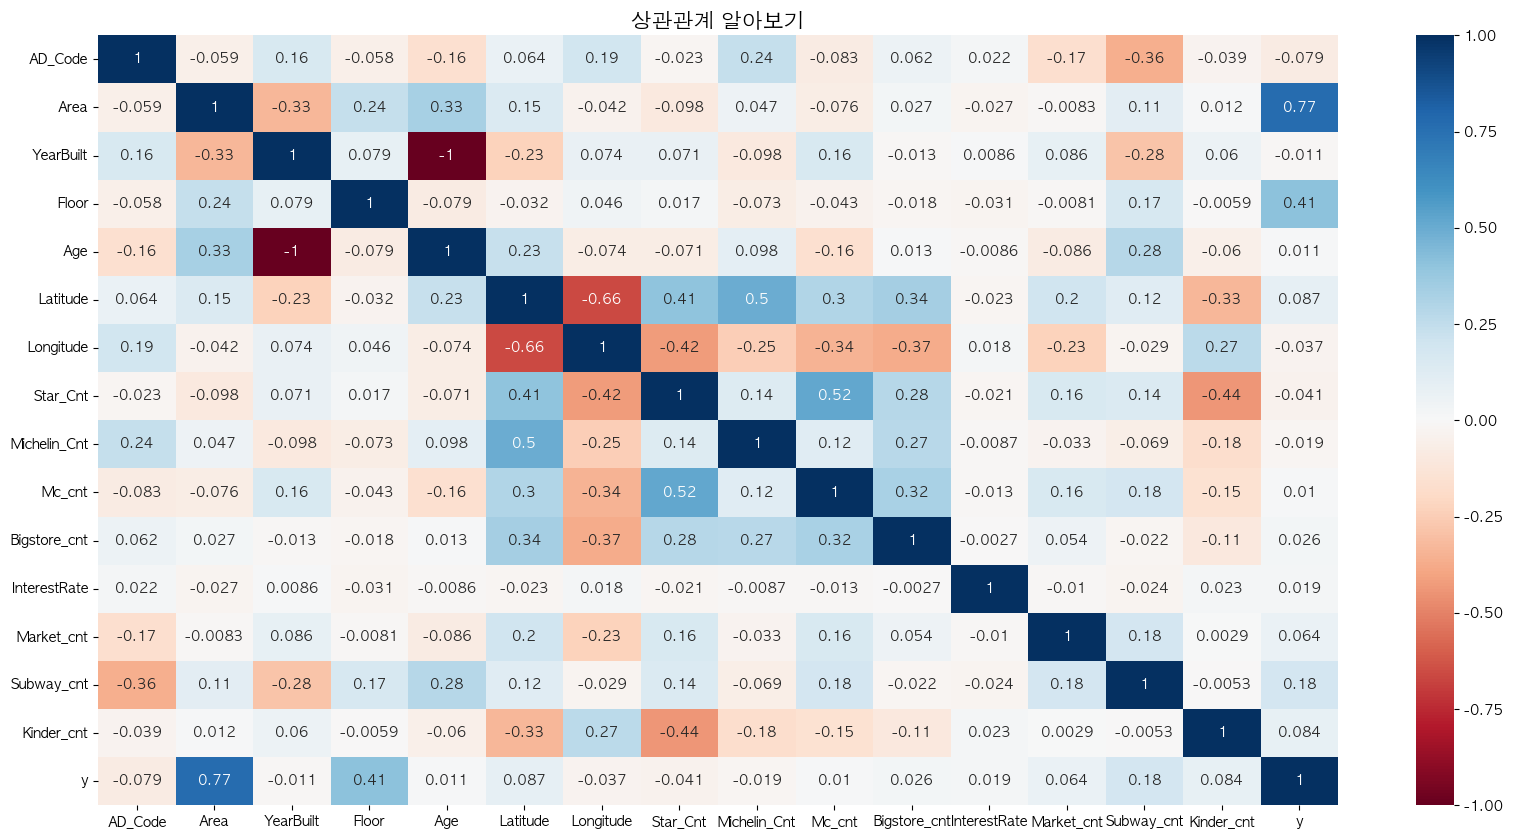

In [70]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap="RdBu", annot=True)
plt.title("상관관계 알아보기", size=15)
plt.show()

In [71]:
# r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
# r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
# r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
# r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
# r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
# r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
# r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

### 가설1:  어떤 계절과 시기에 가격이 높은지? 여름?

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AD_Code         87361 non-null  int64         
 1   Admin_District  87361 non-null  object        
 2   Area            87361 non-null  float64       
 3   YearBuilt       87361 non-null  int64         
 4   Type            87361 non-null  object        
 5   Floor           87361 non-null  float64       
 6   Address         87361 non-null  object        
 7   Cont_Date       87361 non-null  datetime64[ns]
 8   Age             87361 non-null  int64         
 9   Latitude        87361 non-null  float64       
 10  Longitude       87361 non-null  float64       
 11  Star_Cnt        87361 non-null  int64         
 12  Michelin_Cnt    87361 non-null  int64         
 13  Mc_cnt          87361 non-null  int64         
 14  Bigstore_cnt    87361 non-null  int64         
 15  In

In [73]:
df['AD_Code'].value_counts()
df['Admin_District'].value_counts()
df['Type'].value_counts()

9     14741
2     13290
0     10842
3      7445
1      7022
4      6350
11     5586
8      4578
12     4458
6      4141
13     3962
5      2556
7      1624
10      766
Name: AD_Code, dtype: int64

역삼동     14741
대치동     13290
개포동     10842
도곡동      7445
논현동      7022
삼성동      6350
일원동      5586
압구정동     4578
자곡동      4458
수서동      4141
청담동      3962
세곡동      2556
신사동      1624
율현동       766
Name: Admin_District, dtype: int64

아파트      53963
연립다세대    15781
단독다가구     9472
오피스텔      8145
Name: Type, dtype: int64

In [74]:
df.groupby(['Admin_District', 'Type', 'Cont_Date'])['y'].max().sort_values(ascending=False).reset_index()

,Admin_District,Type,Cont_Date,y
0,청담동,아파트,2022-10-13,1100000
1,청담동,아파트,2021-11-12,930000
2,청담동,아파트,2021-02-19,710000
3,청담동,아파트,2021-11-25,700000
4,청담동,아파트,2022-09-27,620000
...,...,...,...,...
34699,신사동,연립다세대,2020-07-14,2000
34700,일원동,연립다세대,2018-01-17,2000
34701,일원동,단독다가구,2018-11-08,1500
34702,일원동,단독다가구,2019-11-20,1500


In [75]:
# 월별로 계절 그룹화 함수 정의
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# 계약년원일['Cont_Date'] 에서 연도와 월 정보를 추출하여 컬럼 추가
df['year'] = df['Cont_Date'].dt.year
df['month'] = df['Cont_Date'].dt.month
df['4seasons'] = df['month'].apply(get_season)

# 연도별, 월별, 계절별로 그룹화
grouped_by_season = df.groupby(['year', 'month', '4seasons'])['y'].sum().reset_index()

# 중복값 제거
grouped_by_season = grouped_by_season.drop_duplicates()

# IQR을 계산하여 이상치 제거
Q1 = grouped_by_season['y'].quantile(0.25)
Q3 = grouped_by_season['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_grouped = grouped_by_season[(grouped_by_season['y'] >= lower_bound) & (grouped_by_season['y'] <= upper_bound)]

print(grouped_by_season)

    year  month 4seasons          y
0   2018      1   Winter   76640949
1   2018      2   Winter   72050887
2   2018      3   Spring   82425650
3   2018      4   Spring   59471787
4   2018      5   Spring   66037407
5   2018      6   Summer   61900499
6   2018      7   Summer   61983672
7   2018      8   Summer   63322296
8   2018      9     Fall   63023537
9   2018     10     Fall   86824675
10  2018     11     Fall   71108125
11  2018     12   Winter   85741645
12  2019      1   Winter   80983800
13  2019      2   Winter   67862001
14  2019      3   Spring   67660520
15  2019      4   Spring   62424101
16  2019      5   Spring   67642385
17  2019      6   Summer   65248368
18  2019      7   Summer   70441155
19  2019      8   Summer   71055595
20  2019      9     Fall   63944138
21  2019     10     Fall   90213464
22  2019     11     Fall   99914501
23  2019     12   Winter  114865134
24  2020      1   Winter   85955319
25  2020      2   Winter   91933218
26  2020      3   Spring   6

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:xlabel='4seasons', ylabel='y'>

Text(0.5, 1.0, '강남구 계절별 보증금 비교')

Text(0.5, 0, '4seasons')

Text(0, 0.5, 'y')

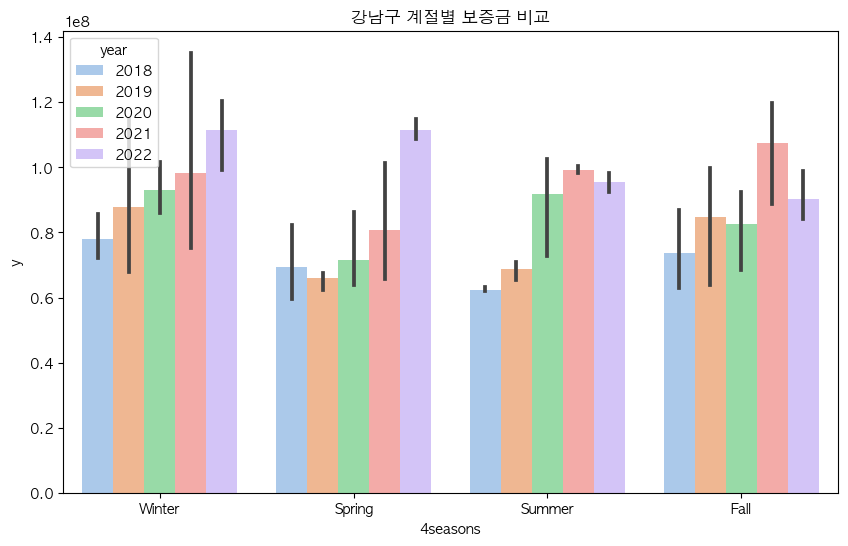

In [84]:
# 연도별, 계절별 보증금 비교 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='4seasons', y='y', hue='year', data=grouped_by_season, palette='pastel')
plt.title('강남구 계절별 보증금 비교')
plt.xlabel('4seasons')
plt.ylabel('y')
plt.legend(title='year')
plt.show()

In [81]:
# import plotly.graph_objects as go

# # 그래프 그리기
# fig = go.Figure()

# for year in grouped_by_season['year'].unique():
#     filtered_data = grouped_by_season[grouped_by_season['year'] == year]
#     fig.add_trace(go.Bar(x=filtered_data['4seasons'], y=filtered_data['y'], name=str(year)))

# # 레이아웃 설정
# fig.update_layout(title='강남구 계절별 보증금 비교', xaxis_title='4seasons', yaxis_title='y')
# fig.update_layout(barmode='group')
# fig.update_layout(legend_title_text='연도')

# # 그래프 표시
# fig.show()

## 강남구 계절별 보증금 비교 결론

    1) 2018, 2019년, 2020년: 겨울 가장 높음
    2) 2021년: 가을 가장 높음
    3) 2022년: 봄, 겨울 가장 높음
    
## 피드백에서 계절별을 숫자로 변경 예정 (머신 러닝시)

    * 0: 봄
    * 1: 여름
    * 2: 가을
    * 3: 겨울
    
## 행정구역별 계절별 보증금 비교 뽑아볼 예정

In [77]:
# AD_Code'와 'Admin_District' 컬럼을 기준으로 매출을 합산하여 일치하는 정보를 추출
matching_info = df.groupby(['AD_Code', 'Admin_District'])['y'].mean().reset_index()
print(matching_info)

    AD_Code Admin_District             y
0         0            개포동  55286.293581
1         1            논현동  36703.247508
2         2            대치동  74517.318360
3         3            도곡동  90857.303962
4         4            삼성동  66120.473858
5         5            세곡동  45321.590376
6         6            수서동  49011.897609
7         7            신사동  34217.506158
8         8           압구정동  87063.072958
9         9            역삼동  44305.838342
10       10            율현동  37152.471279
11       11            일원동  59289.565163
12       12            자곡동  34561.044190
13       13            청담동  73014.908380


In [78]:
# 강남구 평균 보증금 top 5 까지 확인
top_5_highest = matching_info.nlargest(5, 'y')
print(top_5_highest)

    AD_Code Admin_District             y
3         3            도곡동  90857.303962
8         8           압구정동  87063.072958
2         2            대치동  74517.318360
13       13            청담동  73014.908380
4         4            삼성동  66120.473858
